# **NUMERICAL TOOLS FOR QUANTITATIVE FINANCE**
---
<img src="../Imperial_logo.png" align = "left" width=200>
<br><br>
 
- Copyright (c) Antoine Jacquier, 2024. All rights reserved

- Author: Jack Jacquier <a.jacquier@imperial.ac.uk>

- Platform: Tested on Windows 10 with Python 3.9

In [1]:
import numpy as np
import matplotlib.pylab as plt
plt.style.use('dark_background')
import time
import pandas as pd

# Session Overview

- Vectorisation of functions
- Convolutions of functions
- Numerical integration
- Optimisation and root finding
- Application to option pricing

# The importance of vectorisation

## Reminder on iterable types

In [2]:
x_range = range(5)

x_list = [0, 1, 2, 3, 4]

x_array = np.arange(0, 5, 1)

print(x_range, ": ", [x for x in x_range], type(x_range))

print(x_list, type(x_list))

print(x_array, type(x_array))

range(0, 5) :  [0, 1, 2, 3, 4] <class 'range'>
[0, 1, 2, 3, 4] <class 'list'>
[0 1 2 3 4] <class 'numpy.ndarray'>


Multiplication of a `numpy.array` by a real number

In [3]:
print(x_array, " and ",  2.1*x_array)

[0 1 2 3 4]  and  [0.  2.1 4.2 6.3 8.4]


Multiplication of a `list` by a real number

In [4]:
print(x_list, " and ",  2.1*x_list)

TypeError: can't multiply sequence by non-int of type 'float'

Warning though......

In [ ]:
print(x_list, " and ",  2*x_list)

In [ ]:
print(x_range, " and ",  2*x_range)

TAKE-HOME MESSAGE: 
- Use np.array() for computations
- Use lists and ranges for listing or iterations

## Unary functions

Consider a simple function $g(x) = \cos(x)$, that we wish to apply to a vector $(x_i)_{i=1,\ldots, n}$, for some $n\in\mathbb{N}$.
We can either do so by looping over all values of x, or apply the function directly to the vector $x$.
A unary function acts on a single argument, such as np.exp(), np.cos(), np.sqrt()....
They can however be extended to `numpy.array` directly, in which case they also return a `numpy.array`.

In [ ]:
def g(x):
    #Computes the cos
    #x: float
    return np.cos(x)

In [ ]:
n = 1000000
xx = np.random.normal(0., 1., n) ## Generate n Gaussian samples

## Apply the function g() to a list
## Note that in this case we do not output the result
t0 = time.time()
for x in xx:
    g(x) ## Compute g(x)
dtLoop = time.time() - t0

## Apply the function cos() to a list
t0 = time.time()
yyLoop2 = [] ## Creates an empty list
for x in xx:
    yyLoop2.append(g(x)) ## Compute g(x) and add new element to the list
dtLoop2 = time.time() - t0

## Apply the vectorised version of the function cos() to a list
t0 = time.time()
yy1 = np.cos(xx)
dt1 = time.time() - t0

## Same, but directly to the function g()
t0 = time.time()
yy2 = g(xx)
dt2 = time.time() - t0

df = pd.DataFrame([dtLoop, dtLoop2, dt1, dt2], index=["Loop", "Loop2", "cos", "g"], columns=["Time (seconds)"])
df.head()

**Note**: these built-in `numpy` functions can be applied to arrays of any sizes:

In [ ]:
xxx = np.random.normal(0., 1.,  (2, 4, 3))
yyy = g(xxx)
yyy

### Practical example: *computing stock returns*

#### On simulated data

We generate a path as follows.
Consider a sequence of independent and identically distributed (iid) Bernoulli random variables $(X_i)_{i=1,\ldots N}$, so that, for any $i=1,\ldots, N$, 
$\mathbb{P}(X_i=0) = \mathbb{P}(X_i=1) = \frac{1}{2}$ and
$$
\mathbb{E}[X_i] = \frac{1}{2}
\qquad\text{and}\qquad
\mathbb{V}[X_i] = \frac{1}{4}.
$$
We now define, for each $i=1,\ldots N$,
$$
Y_i := 2 X_i - 1,
$$
so that $Y_i$ takes values in $\{-1,1\}$, 
and $\mathbb{E}[Y_i] = 0$, $\mathbb{V}[Y_i] = 1$.

We consider a time horizon $T$ and a time grid $\{t_k = \frac{k}{N}\}_{k=0,\ldots,N}$.
Introduce the discrete-time path
$$
S_{k} := \sqrt{\delta}\sum_{i=1}^{k}Y_i, \quad\text{for }k=1,\ldots, N,
$$
with starting point $S_0 = 0$, for some constant $\delta>0$.
Since the sequence $(Y_i)_{i=1,\ldots N}$ is also iid, we can compute
\begin{align*}
\mathbb{E}[S_k] & = \sqrt{\delta}\sum_{i=1}^{k}\mathbb{E}[Y_i] = 0,\\
\mathbb{V}[S_k] & = \mathbb{V}\left[\sqrt{\delta}\sum_{i=1}^{k}Y_i\right]
 = \delta \sum_{i=1}^{k}\mathbb{V}[Y_i] = \delta k.
\end{align*}
*Note*: taking $\delta=\frac{T}{N}$ allows us to obtain $\mathbb{V}[S_N] = T$, a normalisation that we shall always consider from now on.

In [ ]:
def generate_xys_paths(T, N):
    delta = T/N
    timegrid = np.arange(0,N+1)
    x_path = np.random.binomial(1, .5, size=N)
    y_path = 2.*x_path - 1.
    s_path = np.sqrt(delta) * np.cumsum(y_path)
    s_path = np.insert(s_path, 0, 0.)
    
    return timegrid, x_path, y_path, s_path

def plot_xys_paths(T,N, s_only=True):
    timegrid, x_path, y_path, s_path = generate_xys_paths(T, N)
    if s_only:
        plt.plot(timegrid, s_path, label="S")
        plt.legend(loc="best")
        plt.title("Generate a path of X, Y, S")
        plt.show()
    else:
        plt.plot(timegrid[1:], x_path, '.', label="X")
        plt.plot(timegrid[1:], y_path, '+', label="Y")
        plt.plot(timegrid, s_path, label="S")
        plt.legend(loc="best")
        plt.title("Generate a path of X, Y, S")
        plt.show()
    return None

In [ ]:
T, N = 1., 10000
plot_xys_paths(T,N, s_only=True)

**Question:** is the path of $(S_k)_{k=0,\ldots, N}$ a potentially realistic approximation of a stock price process?

In [ ]:
60*60*7*252

In [ ]:
timegrid, x_path, y_path, s_path = generate_xys_paths(T, N)
asset_path = np.exp(s_path)

In [ ]:
plt.plot(timegrid, asset_path, label="exp(S)")
plt.plot(timegrid, s_path, label="S")
plt.legend(loc="best")
plt.show()

In [ ]:
import time
t0 = time.time()
asset_returns = np.log(asset_path[1:] / asset_path[:-1])
t1 = time.time()
print(t1-t0)

*Note on more precise time computations*

In [48]:
%timeit asset_returns = np.log(asset_path[1:] / asset_path[:-1])

130 µs ± 9.52 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [49]:
t0 = time.time()
asset_returns_loop = []
for i in range(1, len(asset_returns)):
    asset_returns_loop.append(np.log(asset_path[i] / asset_path[i-1]))
t1 = time.time()
print(t1-t0)

0.04770803451538086


What do the log returns look like?

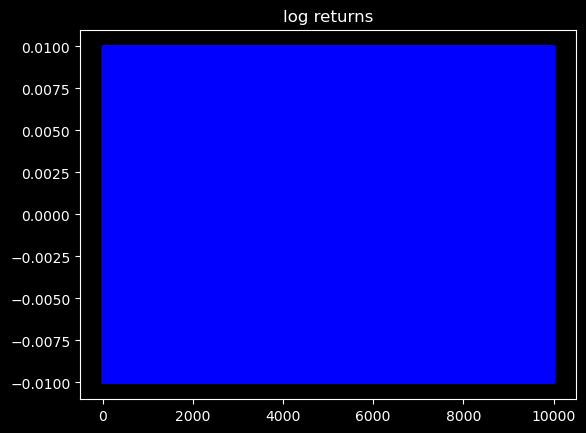

In [50]:
plt.plot(timegrid[1:], asset_returns, 'b')
plt.title("log returns")
plt.show()

##### On real data

In [ ]:
import yahoo_fin.stock_info as si
aapl = si.get_data("aapl") # gets Apple's data
aapl.head()

In [ ]:
#aapl_close = aapl["close"].values
aapl_returns = np.log(aapl["close"] / aapl["close"].shift(1))
aapl_returns.plot();

## Binary functions

A binary function acts on two arguments, such as np.maximum(), np.multiply(), np.power(). 
Again, they are naturally extended to functions on arrays by operating component-wise.

In [51]:
xx = np.random.normal(0., 1., 2)
yy = np.random.normal(0., 1., 2)

print("xx = ", xx)
print("yy = ", yy)

np.add(xx,yy)

xx =  [-1.24107055  1.03894461]
yy =  [-0.52543591  1.25355945]


array([-1.76650646,  2.29250406])

In [53]:
xx = np.random.normal(0., 1., (2,2))
yy = np.random.normal(0., 1., (1,2))

print("xx:")
print(xx)

print("**********************")
print("yy:")
print(yy)


print("**********************")
print("maximum:")
print(np.maximum(xx, yy))

xx:
[[ 1.87888127  0.46436487]
 [-0.36948854 -0.09449539]]
**********************
yy:
[[1.10162894 0.25607763]]
**********************
maximum:
[[1.87888127 0.46436487]
 [1.10162894 0.25607763]]


## Sequential functions

They apply to arrays directly, for example np.mean(), np.std(), np.sum(), np.max().

In [54]:
xx = np.random.normal(0., 1., 10)
print("Sum over a one-dimensional array: ", np.sum(xx))

xx = np.random.normal(0., 1., (4, 6))
print("Sum over a multi-dimensional-dimensional array: ", np.sum(xx))

Sum over a one-dimensional array:  -2.0873159367377956
Sum over a multi-dimensional-dimensional array:  -3.8256398769014703


We already saw above the `np.cumsum` function.

*Exercise: Comparing np.sum(xx) vs sum(xx) vs loop*

In [55]:
def compare_run_times_sum(aa):
    mm, tt = [], []

    ######## LOOP ##########
    t0 = time.time()
    m = 0.
    for a in aa:
        m += a
    dt = time.time() - t0
    mm.append(m)
    tt.append(dt)
    #############################

    ######## BUILT-IN ##########
    t0 = time.time()
    m = sum(aa)
    dt = time.time() - t0
    mm.append(m)
    tt.append(dt)
    #############################

    ######## NUMPY ##########
    t0 = time.time()
    m = np.sum(aa)
    dt = time.time() - t0
    mm.append(m)
    tt.append(dt)
    #############################
    
    df = pd.DataFrame(list(zip(mm, tt)), index=["Loop", "Built-in", "numpy"], columns = ["Sum", "Time"])
    return df

In [66]:
N = 100000

In [63]:
aa = np.random.rand(N) ## Creates a Numpy array of random numbers
print(type(aa))
df = compare_run_times_sum(aa)
df.head()

<class 'numpy.ndarray'>


,Sum,Time
Loop,500413.559539,0.185643
Built-in,500413.559539,0.114554
numpy,500413.559539,0.000000


In [64]:
aa = range(N) ## Creates a range
print(type(aa))
df = compare_run_times_sum(aa)
df.head()

<class 'range'>


,Sum,Time
Loop,4.999995e+11,0.173907
Built-in,4.999995e+11,0.078147
numpy,1.783294e+09,0.117747


In [65]:
aa = list(range(N)) ## Creates a  list
print(type(aa))
df = compare_run_times_sum(aa)
df.head()

<class 'list'>


,Sum,Time
Loop,4.999995e+11,0.093771
Built-in,4.999995e+11,0.046926
numpy,1.783294e+09,0.078124


**Note:** the same holds for *sum*, *max*, *min*, *mean*...

##  The axis keyword

Consider for example the matrix $X = (x_{ij})_{1\leq i\leq m,1\leq j\leq n}\in\mathcal{M}_{m,n}(\mathbb{R})$ with $m$ rows and $n$ columns.
We wish to construct the vector $Y = (y_1,\ldots,y_m) \in\mathbb{R}^{m}$ such that
$$
y_{i} := \sum_{j=1}^{n}x_{ij},
\qquad\text{for each }i=1,\ldots, m.
$$
In `python`, the matrix $X$ is represented by a `numpy.array`. The `axis` keyword allows to apply a function to a slice of it.


In [76]:
xx = np.random.normal(0., 1., (4, 1000000))
print("Dimensions of xx: ", xx.shape)

### Brute force computation of the vector Y
t0 = time.time()
xSum = []
for i in range(xx.shape[0]):
    xSum.append(np.sum(xx[i,:]))
dt = time.time() - t0
print("No slicing -- Sum = ", np.round(xSum, 4), "--- Computation time (seconds): ", np.round(dt, 5))

### Computation of the vector Y by slicing
t0 = time.time()
xSum2 = np.sum(xx, axis=1) 
dt = time.time() - t0
print("   slicing -- Sum = ", np.round(xSum2, 4), "--- Computation time (seconds): ", np.round(dt, 5))

Dimensions of xx:  (4, 1000000)
No slicing -- Sum =  [ 1250.7024 -1906.5424   711.1331 -1747.0458] --- Computation time (seconds):  0.0
   slicing -- Sum =  [ 1250.7024 -1906.5424   711.1331 -1747.0458] --- Computation time (seconds):  0.01566


Computation times are similar since we only loop over 4 elements. Suppose now the first dimension of xx is large:

In [80]:
xx = np.random.normal(0., 1., (100000, 100))
print("Dimensions of xx: ", xx.shape)

### Brute force computation of the vector Y
t0 = time.time()
xSum = []
for i in range(xx.shape[0]):
    #xSum.append(np.sum(xx[i,:]))
    np.sum(xx[i,:])
dt = time.time() - t0
print("No slicing -- Computation time (seconds): ", np.round(dt, 5))

### Computation of the vector Y by slicing
t0 = time.time()
xSum2 = np.sum(xx, axis=1) 
dt = time.time() - t0
print("   slicing -- Computation time (seconds): ", np.round(dt, 5))


Dimensions of xx:  (100000, 100)
No slicing -- Computation time (seconds):  0.90229
   slicing -- Computation time (seconds):  0.0157


## Example: Computing pairwise (Euclidean) distances

Consider two matrices $X\in\mathcal{M}_{d_x, n}(\mathbb{R})$ and $Y\mathcal{M}_{d_y, n}(\mathbb{R})$.
We wish to compute the Euclidean distance
$$
D(X, Y)_{j,k} := \sqrt{\sum_{i=1}^{n}(X_{j,i}-Y_{k,i})^2},
$$
considering the $j$-th row of $X$ and the $k$-th row of $Y$.

The dimensions can be understood as follows for example:

- $d_x$: number of credit lines in Portfolio X
- $d_y$: number of credit lines in Portfolio Y
- n: number of (daily) observations for each credit line

In [70]:
n, dx, dy = 100000, 50, 100
X = np.random.normal(0., 1., (dx, n))
Y = np.random.normal(0., 1., (dy, n))

In [81]:
j, k = 1, 1

## Brute force
t0 = time.time()
dist_jk = np.sqrt(np.sum([(x-y)**2 for (x,y) in zip(X[j,:], Y[k,:])]))
dt = time.time() - t0
print("No slicing -- Distance: ", dist_jk, " --- Total computation time: ", dx*dy*dt)

## Slicing
t0 = time.time()
dist_jk = np.sqrt(np.sum(((X[j]- Y[k])**2)))
dt = time.time() - t0
print("   slicing -- Distance: ", dist_jk, " --- Total computation time: ", dx*dy*dt)

No slicing -- Distance:  447.31373229624995  --- Total computation time:  334.79928970336914
   slicing -- Distance:  447.31373229624995  --- Total computation time:  0.0


## Broadcasting

Broadcasting allows you to perform operations on `numpy` arrays of different dimensions. 

The compatibility criteria for broadcasting two arrays are as follows:
- align their shapes from right to left
- check that each pair of aligned dimensions satisfy either of the following conditions:
    - the aligned dimensions are the same;
    - one of the dimensions has a size of 1.

Simple example:

In [82]:
xx = np.random.normal(0., 1., (2,5))
zz = xx + 1.
print("X shape: ", xx.shape)
print("Z shape: ", xx.shape)

X shape:  (2, 5)
Z shape:  (2, 5)


In [90]:
def print_broadcasting_sum(xx, yy):
    
    zz = xx + yy

    print("X shape: ", xx.shape)
    print("Y shape: ", yy.shape)
    print("Z shape: ", zz.shape)

    return None


In [91]:
xx = np.random.normal(0., 1., (2,5))
yy = np.random.normal(0., 1., (2,5))

print_broadcasting_sum(xx, yy)

X shape:  (2, 5)
Y shape:  (2, 5)
Z shape:  (2, 5)


In [94]:
xx = np.random.normal(0., 1., (2, 5, 3))
yy = np.random.normal(0., 1., (5, 3))

print_broadcasting_sum(xx, yy)

X shape:  (2, 5, 3)
Y shape:  (5, 3)
Z shape:  (2, 5, 3)


The point is that the loop computation is done in `C` and not in `python` anymore, and without making needless copies of the data.

####  Back to Euclidean distances...

In [104]:
t0 = time.time()
X1 = X.reshape(dx, 1, n)
Y1 = Y.reshape(1, dy, n)
diffs = X1 - Y1
dists = np.sqrt(np.sum(diffs**2, axis=2))
dt = time.time() - t0
print("   slicing -- Distance: ", dists.shape, np.round(dists[j,k], 4), " --- Computation time: ", np.round(dt, 4))

t0 = time.time()
dists = np.sqrt(np.sum((X[:, np.newaxis] - Y[np.newaxis])**2, axis=2)) ## same as the reshaping above
dt = time.time() - t0
print("   slicing -- Distance: ",  dists.shape, np.round(dists[j,k], 4), " --- Computation time: ", np.round(dt, 4))

Distance:  (50, 100) 447.3137  --- Computation time:  12.9473
Distance:  (50, 100) 447.3137  --- Computation time:  9.7816


As soon as the dimension $n$ gets large, the computation time becomes too large.

Optimised broadcasting:

In [109]:
t0 = time.time()
dists = -2 * np.matmul(X, Y.T)
dists +=  np.sum(X**2, axis=1)[:, np.newaxis]
dists += np.sum(Y**2, axis=1)
di = np.sqrt(dists[j,k])
dt = time.time() - t0
print("Broadcasting -- Distance: ", np.round(di, 4), " --- Computation time: ", np.round(dt, 4))

Broadcasting -- Distance:  447.3137  --- Computation time:  0.2553


## More involved functions?

In [110]:
def f(x):
    if x < 0.:
        return np.cos(x)
    else:
        return np.exp(-x)

In [111]:
xx = np.random.normal(0.,1., 5)
f(xx)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
fVec = np.vectorize(f)
N = 1000000
xx = np.random.normal(0., 1., N)

t0 = time.time()
yyLoop = []
for x in xx:
    yyLoop.append(f(x))
dtLoop = time.time() - t0

t0 = time.time()
yyv = fVec(xx)
dtv = time.time() - t0

t0 = time.time()
yyv2 = [f(x) for x in xx]
dtv2 = time.time() - t0

df = pd.DataFrame([dtLoop, dtv, dtv2], index=["Loop", "Vec", "Iter"], columns=["Time (seconds)"])
df.head()

**Note:** The `vectorize` function is provided primarily for convenience, not for performance. The implementation is essentially a for loop.

## Convolutions

In [112]:
def new_func(g, x):
    return g(x) ** 2

In [113]:
print("Calling a numpy function: ", new_func(np.cos, -2.))
print("Calling a function defined previously: ", new_func(f, -2.))

Calling a numpy function:  0.17317818956819406
Calling a function defined previously:  0.17317818956819406


# Going faster? Parallel processing and multiprocessing

https://wiki.python.org/moin/ParallelProcessing

..... Later in the term .....


# A quick note on `numba` and `jit`

https://numba.pydata.org/

We would like to build an estimator for $\pi$. Since the area of a circle of radius $R$ is equal to $\pi R^2$, we can randomly draw samples $(X_i,Y_i)_{i=1,\ldots,n}$ uniformly from the positive quadrant of the unit square $[0,1]^2$ and estimate $\pi$ as
$$
\widehat{\pi}_n := \frac{4}{R^2}\frac{1}{n}\sum_{i=1}^{n}\boldsymbol{1}_{\{X_i^2 + Y_i^2\leq 1\}}.
$$
Note that it is clearly an unbiased and convergent estimator.

In [48]:
import numpy as np
import matplotlib.pylab as plt
import time

In [36]:
def monte_carlo_pi_plot(n):
    """
    n: number of samples

    """
    nbpoints_in = 0.
    data_x = []
    data_y = []
    data_colours = ["b"]*n
    
    for i in range(n):
        x = np.random.rand()
        y = np.random.rand()
        data_x.append(x)
        data_y.append(y)
        
        if (x ** 2 + y ** 2) <= 1.0:
            nbpoints_in += 1
            data_colours[i] = "r"
            
    return 4. * nbpoints_in / n, data_x, data_y, data_colours

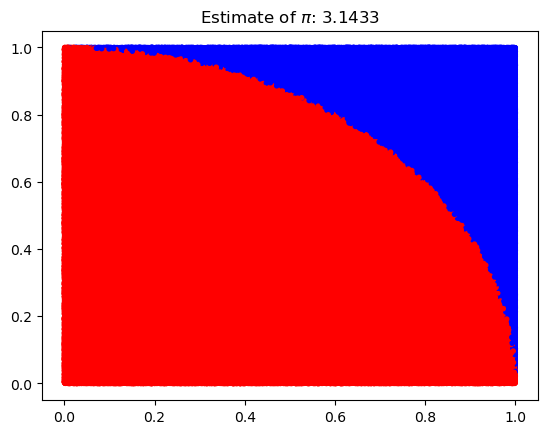

In [62]:
n = 1000000
pi_est, data_x, data_y, data_colours = monte_carlo_pi_plot(n)
plt.scatter(data_x, data_y, c=data_colours, marker=".")
plt.title(r'Estimate of $\pi$: %.4f' %np.round(pi_est,4))
plt.show()

Same version, but removing the plot part

In [64]:
def monte_carlo_pi(n):
    nbpoints_in = 0.
    for i in range(n):
        x = np.random.rand()
        y = np.random.rand()
        if (x ** 2 + y ** 2) <= 1.0:
            nbpoints_in += 1
    return 4. * nbpoints_in / n

**Warning:** there is a loop. Can we get rid of it?

In [65]:
def monte_carlo_pi_noloop(n):
    x = np.random.rand(n)
    y = np.random.rand(n)
    nbpoints_in = sum((x ** 2 + y ** 2) <= 1.0)
    return 4. * nbpoints_in / n

Let's compare the computation times

In [66]:
n = 1000000
t0 = time.time()
pi_est_loop = monte_carlo_pi(n)
dt = time.time() - t0

t0 = time.time()
pi_est_noloop = monte_carlo_pi_noloop(n)
dt_q = time.time() - t0

print("   Loop time:", np.round(pi_est_loop, 3), "|", dt)
print("No loop time:", np.round(pi_est_noloop, 3), "|", dt_q)

   Loop time: 3.142 | 1.6484153270721436
No loop time: 3.142 | 0.17295265197753906


### Doing it with `numba`

In [82]:
from numba import jit

@jit(nopython=True)
def monte_carlo_pi_jit(n):
    nbpoints_in = 0.
    for i in range(n):
        x = np.random.rand()
        y = np.random.rand()
        if (x ** 2 + y ** 2) < 1.:
            nbpoints_in += 1
    return 4. * nbpoints_in / n

In [83]:
@jit(nopython=True)
def monte_carlo_pi_jit_noloop(n):
    x = np.random.rand(n)
    y = np.random.rand(n)
    nbpoints_in = sum((x ** 2 + y ** 2) < 1.)
    return 4. * nbpoints_in / n

In [86]:
n = 1000000

t0 = time.time()
pi_mc = monte_carlo_pi(n)
dt = time.time() - t0

t0 = time.time()
pi_jit = monte_carlo_pi_jit(n)
dt_jit = time.time() - t0

t0 = time.time()
pi_est_noloop = monte_carlo_pi_noloop(n)
dt_noloop = time.time() - t0

t0 = time.time()
pi_est_jit_noloop = monte_carlo_pi_jit_noloop(n)
dt_jit_noloop = time.time() - t0

print("numpy         || value:", np.round(pi_mc, 3), "-- Computation time:", np.round(dt, 4))
print("numba         || value:", np.round(pi_jit, 3), "-- Computation time:", np.round(dt_jit, 4))
print("numpy no loop || value:", np.round(pi_est_noloop, 3), "-- Computation time:", np.round(dt_noloop, 4))
print("numba no loop || value:", np.round(pi_est_jit_noloop, 3), "-- Computation time:", np.round(dt_jit_noloop, 4))

numpy         || value: 3.144 -- Computation time: 1.7611
numba         || value: 3.143 -- Computation time: 0.0156
numpy no loop || value: 3.142 -- Computation time: 0.1665
numba no loop || value: 3.142 -- Computation time: 0.0314


*Isn't it supposed to work faster?*
.....Let's run it again......

In [87]:
n = 1000000

t0 = time.time()
pi_mc = monte_carlo_pi(n)
dt = time.time() - t0

t0 = time.time()
pi_jit = monte_carlo_pi_jit(n)
dt_jit = time.time() - t0

t0 = time.time()
pi_est_noloop = monte_carlo_pi_noloop(n)
dt_noloop = time.time() - t0

t0 = time.time()
pi_est_jit_noloop = monte_carlo_pi_jit_noloop(n)
dt_jit_noloop = time.time() - t0

print("numpy         || value:", np.round(pi_mc, 3), "-- Computation time:", np.round(dt, 4))
print("numba         || value:", np.round(pi_jit, 3), "-- Computation time:", np.round(dt_jit, 4))
print("numpy no loop || value:", np.round(pi_est_noloop, 3), "-- Computation time:", np.round(dt_noloop, 4))
print("numba no loop || value:", np.round(pi_est_jit_noloop, 3), "-- Computation time:", np.round(dt_jit_noloop, 4))

numpy         || value: 3.139 -- Computation time: 1.8463
numba         || value: 3.139 -- Computation time: 0.0156
numpy no loop || value: 3.14 -- Computation time: 0.1743
numba no loop || value: 3.142 -- Computation time: 0.0156


In [90]:
n = 10*n

In [94]:
%timeit monte_carlo_pi_jit(n)

175 ms ± 4.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [95]:
%timeit monte_carlo_pi_jit_noloop(n)

289 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's try `numba` to integrate a function using the quad` module, say for example
$$
\int_{l}^{u}x^2\mathrm{d}x.
$$

In [96]:
from scipy.integrate import quad

def test_nojit(lbound, ubound):
    def f_to_integrate(x):
        return x**2
    output = quad(f_to_integrate, lbound, ubound)
    return output

@jit(nopython=True)
def test_jit(lbound, ubound):
    def f_to_integrate(x):
        return x**2
    output = quad(f_to_integrate, lbound, ubound)
    return output

In [97]:
test_nojit(-2., 2.)
test_jit(-2., 2.)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'quad':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_9288\382380213.py", line 13:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

**Note:** `numba` only supports a limited number of features: https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

### `numba`-ing functions

Assume that we wish to compute the expectation $\mathfrak{E}:=\mathbb{E}[\cos(X)]$, where $X$ is a Uniform random variable on the closed interval $[0,1]$.
We can compute the empirical mean
$$
\widehat{\mathfrak{E}}_{n}:=\frac{1}{n}\sum_{i-1}^{n}\cos(X_i),
$$
where $(X_i)_{i=1,\ldots,n}$ is an iid sequence distributed as $\mathcal{U}_{[0,1]}$.
Standard probability theory tells us that this is an unbiased and convergent estimator as $n$ tends to infinity.

In [98]:
import numba as nb

def monte_carlo_vec(nsimul):
    expect = 0.
    for i in range(nsimul):
        x = np.random.rand()
        cos_x = np.cos(x)
        expect += cos_x
    return expect / nsimul
    
monte_carlo_vec_jit = nb.jit(monte_carlo_vec, nopython=True)

nsimul = 10000

t0 = time.time()
res_mc = monte_carlo_vec(nsimul)
dt = time.time() - t0

t0 = time.time()
res_mc_jit = monte_carlo_vec_jit(nsimul)
dt_jit = time.time() - t0

print("numpy Computation time:", dt)
print("numba Computation time:", dt_jit)

numpy Computation time: 0.06994056701660156
numba Computation time: 0.23887920379638672


### Computation time analysis

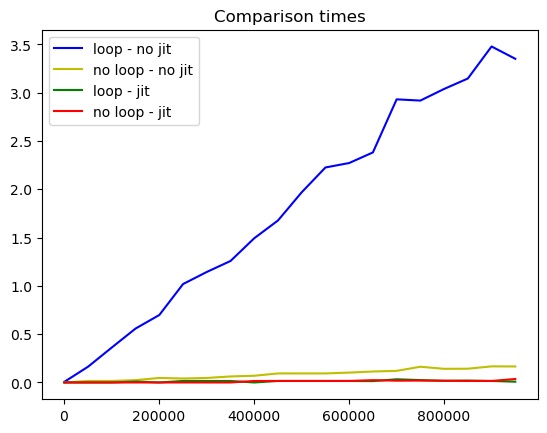

In [110]:
nn = np.arange(1000, 1000000, 50000)
dts, dt_noloops, dt_jit_loops, dt_jit_noloops = [], [], [], []

for n in nn:
    t0 = time.time()
    res_mc = monte_carlo_vec(n)
    dt = time.time() - t0
    dts.append(dt)

    t0 = time.time()
    pi_est_noloop = monte_carlo_pi_noloop(n)
    dt_noloop = time.time() - t0
    dt_noloops.append(dt_noloop)

    t0 = time.time()
    res_mc_jit = monte_carlo_vec_jit(n)
    dt_jit_loop = time.time() - t0
    dt_jit_loops.append(dt_jit_loop)

    t0 = time.time()
    pi_est_jit_noloop = monte_carlo_pi_jit_noloop(n)
    dt_jit_noloop = time.time() - t0
    dt_jit_noloops.append(dt_jit_noloop)

plt.figure(figsize=(8,3))
plt.plot(nn, dts, 'b', label="loop - no jit")
plt.plot(nn, dt_noloops, 'y', label="no loop - no jit")
plt.plot(nn, dt_jit_loops, 'g', label="loop - jit")
plt.plot(nn, dt_jit_noloops, 'r', label="no loop - jit")
plt.legend(loc="best")
plt.title("Comparison times")
plt.show()

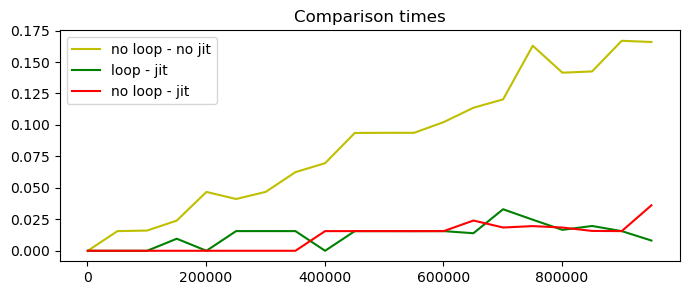

In [112]:
plt.figure(figsize=(8,3))
plt.plot(nn, dt_noloops, 'y', label="no loop - no jit")
plt.plot(nn, dt_jit_loops, 'g', label="loop - jit")
plt.plot(nn, dt_jit_noloops, 'r', label="no loop - jit")
plt.legend(loc="best")
plt.title("Comparison times")
plt.show()

# Numerical integration

In [5]:
from scipy.integrate import quad, simps
import matplotlib.pylab as plt
import numpy as np

**GOAL:** Integrate the density of a centered Gaussian random variable with variance $\sigma^2>0$.
$$
f_{\sigma}(x) = \frac{1}{\sigma\sqrt{2\pi}}\exp\left\{-\frac{x^2}{2\sigma^2}\right\}.
$$

In [6]:
def gauss_density(x, sig):
    return np.exp(-x*x / (2.*sig*sig)) / (sig*np.sqrt(2.*np.pi))

We wish to integrate the functions on the interval [-5, 5]. 

First Step: always plot the functions to be studied.

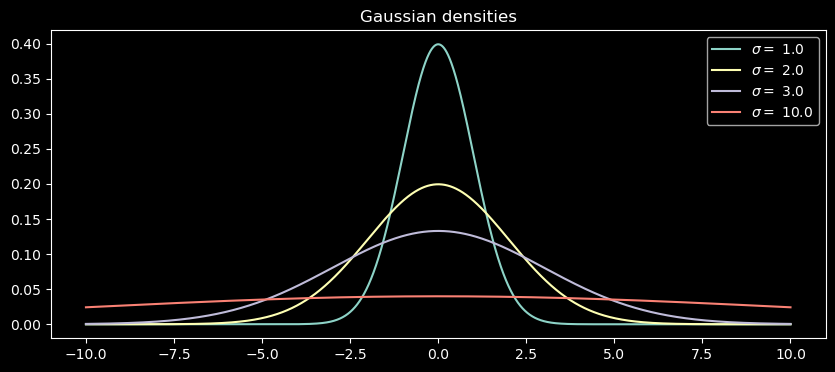

In [7]:
xMin, xMax = -10., 10.
sigmas = [1., 2., 3., 10.]
xx = np.linspace(xMin, xMax, 10000)

plt.figure(figsize=(10,4))
gauss_densities = []
for sig in sigmas:
    
    gauss_densities.append([gauss_density(x,sig) for x in xx])
    plt.plot(xx, gauss_densities[-1], label='$\sigma=$ %.1f' %sig)
    
plt.title("Gaussian densities")
plt.legend(loc='best')
plt.show()

Numerical integration documentation: 
- Simpson's rule: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.simps.html
- Adaptive quadrature: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html

In [8]:
print('Numerical integration for f:')
print("***************************")
for (i,sig) in enumerate(sigmas):
    print('sigma=', sig)
    qf = quad(gauss_density, xMin, xMax, args=(sig,))
    qs = simps(gauss_densities[i], xx)
    print("Quadrature value: ", qf[0], "|| Quadrature error: ", qf[1])
    print("   Simpson value: ", qs)
    print("***************************")

Numerical integration for f:
***************************
sigma= 1.0
Quadrature value:  1.0000000000000002 || Quadrature error:  8.671029888166837e-10
   Simpson value:  1.0
***************************
sigma= 2.0
Quadrature value:  0.9999994266968565 || Quadrature error:  8.668320228277793e-10
   Simpson value:  0.9999994266968562
***************************
sigma= 3.0
Quadrature value:  0.9991418793336064 || Quadrature error:  2.7553471860348143e-14
   Simpson value:  0.9991418793336059
***************************
sigma= 10.0
Quadrature value:  0.6826894921370861 || Quadrature error:  7.579375928402477e-15
   Simpson value:  0.682689492137086
***************************


# Optimisation and root-finding

We investigate some of the importants routines within the `scipy.optimize` package https://docs.scipy.org/doc/scipy/reference/optimize.html

## Root finding

We are interested in finding the (unique?) solution to the equation
\begin{equation*}
f(x) = 0,
\end{equation*}
over some given interval.

We consider for example the function $f(x) = x^2 - 1$.

In [9]:
from scipy.optimize import fsolve, root, minimize

def f(x):
    return x**2 - 1.
    
print("Solution: x =", fsolve(f, x0=-0.2)[0])

Solution: x = -1.0


Note that this is a local solver, that needs a starting estimate. It also works in the multidimensional setting.
Consider for example the function
$$
f(\boldsymbol{\mathrm{x}}) = (x_1^{2} + x_2^{2} - 1, x_1 - x_{2}),
$$
and we want to solve the root-finding problem
$$
f(\boldsymbol{\mathrm{x}}) = (0,0), \qquad\text{on }\mathbb{R}^2.
$$
Clearly, since the first equation $x_1^{2} + x_2^{2} - 1=0$ is that of the circle, and the second one $x_1 - x_{2}=0$ that of a line, we are merely looking for the intersection between both.

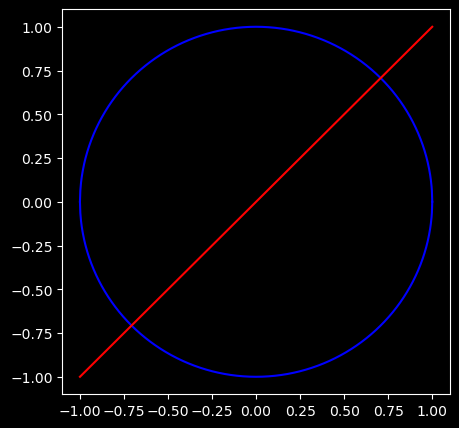

In [10]:
def f(x):
    return [x[0]**2 + x[1]**2 - 1., x[0] - x[1]]

aa = np.linspace(-1.,1.,1000)
cirP = np.sqrt(1.-aa**2)
cirM = -np.sqrt(1.-aa**2)
lin = [a for a in aa]

plt.figure(figsize=(5,5))
plt.plot(aa,cirP, 'b')
plt.plot(aa,cirM, 'b')
plt.plot(aa,lin,'r')
plt.show()

In [11]:
#### Starting point for the solver
x0 = [.2, .4]

In [12]:
x_star = fsolve(f, x0)
print("Optimal solution: ", x_star, "|| Value at optimum:", f(x_star))

Optimal solution:  [0.70710678 0.70710678] || Value at optimum: [2.220446049250313e-16, 0.0]


Note, this is a local solver and only returns one solution only. In order to retrieve all the solutions, 
one possibility is to randomise the initial value of $x_0$.
In this context, using a `set` can be very convenient:

In [13]:
x_star_values = set([])
for _ in range(100):
    x0 = 2.*np.random.rand(2) - 1. ## we randomise on [-1,1]^2
    x_star_values.add(tuple(np.round(fsolve(f, x0), 5)))

print("List of optimal values: ", x_star_values)

List of optimal values:  {(-0.70711, -0.70711), (0.70711, 0.70711)}


We could also use the `root` module, which provides detailed information.

In [14]:
print(root(f, x0))

 message: The solution converged.
 success: True
  status: 1
     fun: [-2.220e-16  0.000e+00]
       x: [-7.071e-01 -7.071e-01]
    nfev: 11
    fjac: [[ 4.303e-01 -9.027e-01]
           [ 9.027e-01  4.303e-01]]
       r: [-1.108e+00 -1.093e-01 -2.553e+00]
     qtf: [-1.545e-13 -3.241e-13]


## Optimisation

**Remark:** Root-finding problems can be recast as minimisation problem. For example, solving $f(x) = c$ can be tackled as
\begin{equation*}
\min_{x} \left[f(x)-c\right]^2.
\end{equation*}

When solving an optimisation problem of the form $min_{x}g(x)$, we first need to consider the following question:
- Is the objective function $g$ convex?
- Is the objective function $g$ smooth, i.e. is its gradient defined everywhere?
- Are there constraints?

### One-dimensional optimisation

In [15]:
from scipy.optimize import minimize_scalar
def f(x):
    return x*x-1.

def f2(x):
    return f(x)**2

result = minimize_scalar(f2)
print(result)
print("*******************")
result2 = minimize_scalar(f2, bounds=(-4., 0.), method='bounded')
print(result2)

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 0.0
       x: 1.0
     nit: 8
    nfev: 11
*******************
 message: Solution found.
 success: True
  status: 0
     fun: 8.127928729108361e-13
       x: -1.0000004507750289
     nit: 11
    nfev: 11


# Pricing Options in the Black-Scholes model

## Option Pricing

A European Call option on some stock $(S_t)_{t\geq 0}$ gives the holder the right (but not the obligation) to exchange the stock at a future time $T$ for a given price $K$.
The initial value of such an option is therefore (by no-arbitrage arguments):
\begin{equation*}
C(S_0, K, T) = \mathbb{E}\left[(S_T-K, 0)_{+}\right] = \mathbb{E}\left[\max(S_T-K, 0)\right] = 
\mathbb{E}\left[(S_{T}-K)\mathbb{1}_{\{S_T\geq K\}} + 0\cdot\boldsymbol{1}_{\{S_T< K\}}\right].
\end{equation*}
*Note: We consider no interest rate nor dividends here*.

## A quick and dirty introduction to Black-Scholes

The Black–Scholes model is one of the cornerstones of mathematical finance.
It assumes that the underlying stock price has the following dynamics:
$$
S_t
 = S_0\exp\left\{-\frac{\sigma^2 t}{2} + \sigma W_t\right\}
 = S_0\exp\left\{-\frac{\sigma^2 t}{2} + \sigma\widetilde{N}\sqrt{t}\right\} \text{ (in distribution)},
$$
for each $t\geq 0$, for some constant $\sigma>0$, and where $\widetilde{N}$ is a standard Gaussian random variable.
Here $(W_t)_{t\geq 0}$ is a standard Brownian motion, and satisfies:
- $W_0 = 0$ almost surely;
- for any $0\leq s \leq t$, the increment $W_t - W_s$ is a Gausssian random variable with mean zero and variance $t-s$;
- non-overlapping increments are independent, namely the random variables $W_{t_4} - W_{t_3}$ and $W_{t_2} - W_{t_1}$ are independent for any $0\leq t_1 < t_2\leq t_3 < t_4$.

The value of a European Call option on $(S_t)_{t\geq 0}$ in the Black-Scholes model is given, at time zero, by
$$
C^{\mathrm{BS}}(S_0, K, T;\sigma) = \mathbb{E}\left[\max(S_{T} - K, 0)\right]
 = S_0\left(\mathcal{N}(d_{+}) - \mathrm{e}^{k}\mathcal{N}(d_{-})\right),
$$
where
$$
d_{\pm} = \frac{-k}{\sigma\sqrt{T}} \pm\frac{\sigma\sqrt{T}}{2}
$$
and
- $k := \log\left(K / S_0\right)$ is called the log moneyness;
- $\mathcal{N}(\cdot)$ is the cumulative distribution function of the standard Normal distribution, namely 
 $\mathcal{N}(x) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}\exp\left\{-\frac{z^2}{2}\right\}\mathrm{d}z$, for all $x\in\mathbb{R}$;
- $T$ is the time to maturity;
- $S_0$ is the spot price of the underlying asset;
- $K$ is the strike price;
- $\sigma$ is the volatility  of returns of the underlying asset.


## Pricing via the closed-form formula

In [16]:
from scipy.stats import norm
import numpy as np

def blackscholes_call(S0, K, sigma, T):
    '''
    #Inputs:
    S0: initial stock price
    K: strike
    sigma: instantaneous volatility
    T: time to maturity
    #Output:
    Black-Scholes Call price
    '''
    sigmaT = sigma*np.sqrt(T)
    k = np.log(K/S0)
    dp = -k / sigmaT + 0.5*sigmaT
    dm = dp - sigmaT
    return S0*(norm.cdf(dp) - np.exp(k)*norm.cdf(dm))

In [17]:
S0, K, sigma, T = 100., 100., 0.2, 1.
print("Black-Scholes Call option price:", blackscholes_call(S0,K,sigma,T))

Black-Scholes Call option price: 7.965567455405798


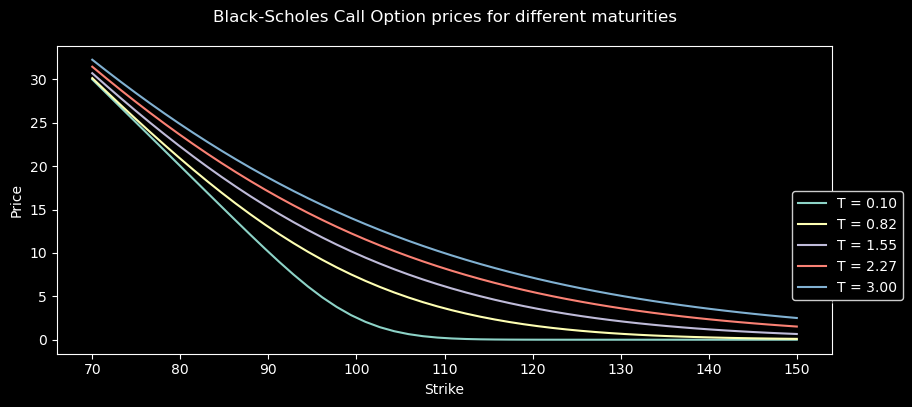

In [19]:
TT = np.linspace(0.1,3.,5)
strikes = np.linspace(70., 150, 50)
plt.figure(figsize=(10, 4))

for T in TT:
    plt.plot(strikes, [blackscholes_call(S0,K,sigma,T) for K in strikes], label='T = %.2f' %T)

plt.legend(loc='best', bbox_to_anchor=(1.1, 0.55),fancybox=True, shadow=True, ncol=1)
plt.title('Black-Scholes Call Option prices for different maturities',y=1.05,fontsize=12)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.show()

*Note:  one could also vectorise the Black-Scholes function first.*

## Pricing by integration

Recall that under the Black-Scholes model, the stock price satisfies at maturity $T$,
\begin{equation*}
S_T
 = S_0\exp\left\{-\frac{\sigma^2 T}{2} + \sigma\widetilde{N}\sqrt{T}\right\},
\end{equation*}
where $\widetilde{N}$ is a Gaussian random variable. 
Therefore, for any function $f:\mathbb{R}_+\to\mathbb{R}$ such that the expectation exists, we can write
\begin{equation*}
\mathbb{E}\left[f(S_T)\right] = 
\mathbb{E}\left[f\left(S_0\exp\left\{-\frac{\sigma^2 T}{2} + \sigma\widetilde{n}\sqrt{T}\right\}\right)\right] =
\int_{\mathbb{R}}f\left(S_0\exp\left\{-\frac{\sigma^2 T}{2} + \sigma x\sqrt{T}\right\}\right)\varphi(x) \mathrm{d} x,
\end{equation*}
where the Gaussian density reads
\begin{equation*}
\varphi(x) := \partial_{x}\mathcal{N}(x) = \frac{1}{\sqrt{2\pi}}\exp\left\{-\frac{x^2}{2}\right\}.
\end{equation*}

**Exercise (see also the assignment):** Check the Black-Scholes price by integration. Hints / advice:
- Plot the integrand as a function of $x$ to determine how to truncate the real line (integration domain);
- Use different numerical integration packages to compute the expectation and compare with the closed-form expression.

## Pricing by simulation

### Simulating Brownian motion with the Euler-Maruyama method
Leonhard Euler (1707 – 1783, Swiss) and Gisiro Maruyama (1916 – 1986, Japanese)

A Brownian motion $(W_t)_{t\geq 0}$ has the following properties:
- $W_0 = 0$;
- For any $t \geq 0$, $\delta \in (0,t)$, $W_{t+\delta} - W_{t}$ is distributed as a Gaussian with mean zero and variance $\delta$;
- For any $0\leq s < t \leq u < v$, 
the increments $(W_v - W_u)$ and $(W_t-W_s)$ are independent.

Therefore, on the interval $[0,T]$, create a partition $0=t_0< \cdots < t_i < t_{i+1}<\cdots<t_n=T$, so that
$$
W_T = W_{t_n} = \left(W_{t_n} - W_{t_{n-1}}\right) + \cdots + \left(W_{t_1} - W_{t_{0}}\right).
$$
Using Property (ii) above, this is equal in distribution to
$$
W_T = W_{t_n} = \sqrt{t_n-t_{n-1}}\ \widetilde{N}_{n-1} + \cdots +\sqrt{t_{1}-t_{0}}\ \widetilde{N}_{0},
$$
where the sequence $(\widetilde{N}_{i})_{i}$ is iid centered Gaussian with unit variance.

We will solely focus on equidistant time grids, namely with $t_{i} = \frac{iT}{n}$, for $i=0,\ldots, n$.

In [28]:
T, n, nbPaths = 1., 1000, 50
tt = np.linspace(0., T, n) ## Equidistant discretisation grid
dt = tt[1] - tt[0]

Computation time:  0.4057126045227051  seconds


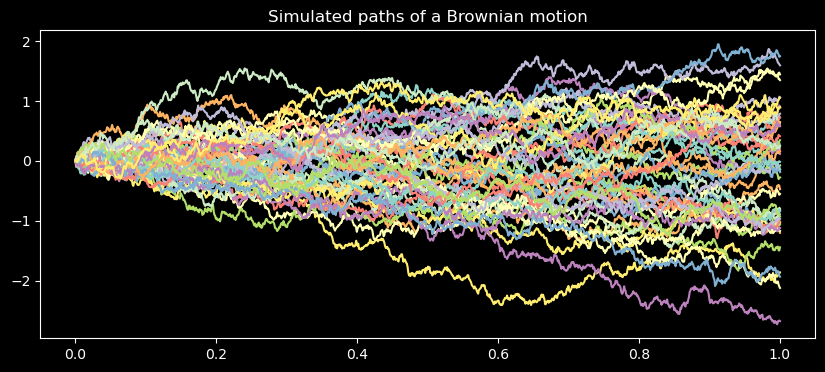

In [29]:
t0 = time.time()
ww = np.zeros((n, nbPaths)) ## The Brownian motion starts at zero

for path in range(nbPaths):
    for (i,t) in enumerate(tt[:-1]):
        ww[i+1,path] = ww[i,path] + np.sqrt(dt) * np.random.normal(0.,1.)
t1 = time.time()-t0
print("Computation time: ", t1, " seconds")

plt.figure(figsize=(10,4))
for path in range(nbPaths):
    plt.plot(tt, ww[:, path])
plt.title("Simulated paths of a Brownian motion")
plt.show()

**Question:** What can be improved in the code above?

Computation time:  0.192535400390625  seconds


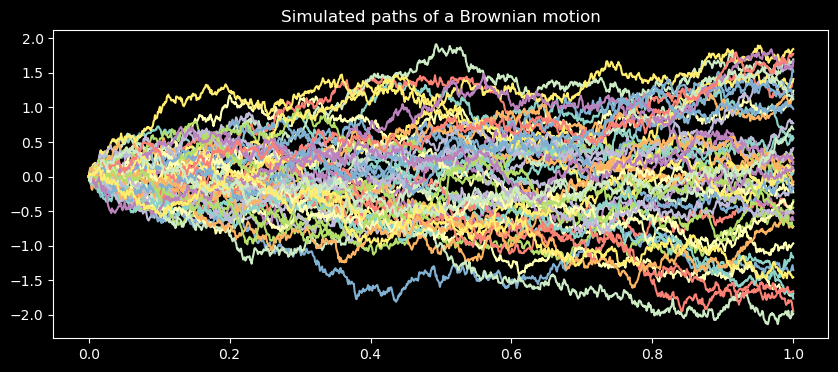

In [30]:
t0 = time.time()
ww = np.zeros((n, nbPaths)) ## The Brownian motion starts at zero
N = np.random.normal(0.,1., (nbPaths, n-1))

for path in range(nbPaths):
    for (i,t) in enumerate(tt[:-1]):
        ww[i+1,path] = ww[i,path] + np.sqrt(dt) * N[path,i]
t1 = time.time()-t0
print("Computation time: ", t1, " seconds")

plt.figure(figsize=(10,4))
for path in range(nbPaths):
    plt.plot(tt, ww[:, path])
plt.title("Simulated paths of a Brownian motion")
plt.show()

### Using `numpy` vectorisation

Computation time:  0.011725187301635742  seconds


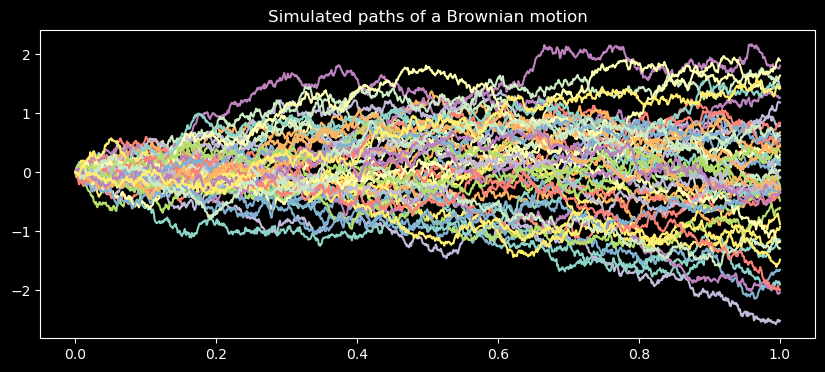

In [31]:
t0 = time.time()
nn = np.random.normal(0., 1., (n-1, nbPaths)) * np.sqrt(dt)
ww = np.zeros((n, nbPaths))
ww[1:,:] = np.cumsum(nn, axis=0)
t1 = time.time()-t0
print("Computation time: ", t1, " seconds")

plt.figure(figsize=(10,4))
for path in range(nbPaths):
    plt.plot(tt, ww[:, path])
plt.title("Simulated paths of a Brownian motion")
plt.show()

## The Euler&ndash;Maruyama method

Consider the stochastic differential equation
$$
\mathrm{d}X_t = a(X_t) \, \mathrm{d}t + b(X_t) \, \mathrm{d}W_t,
$$
with initial condition $X_0 = x_0$, where $W_t$ stands for the Wiener process.

The **Euler&ndash;Maruyama approximation** to the true solution $X$ is the Markov chain $\widehat{X}$ defined as follows:

* Partition the interval $[0, T]$ into subintervals:
$$0 = t_0 < t_1 < t_2 < \ldots < t_{n-1} < t_n = T,$$
and consider
\begin{equation*}
\begin{array}{rlll}
\Delta t_0 = t_1 - t_0, & \Delta t_1 = t_2 - t_2, & \ldots, & \Delta t_{n-1} = t_n - t_{n-1},\\
\Delta W_0 = W_{t_1} - W_{t_0}, & \Delta W_1 = W_{_2} - W_{t_1}, & \ldots, & \Delta W_{t_{n-1}} = W_{t_n} - W_{t_{n-1}}.
\end{array}
\end{equation*}
It is quite common to again consider a regular time grid, namely $\Delta t_i = \Delta t_j$ for any $i,j=0,\ldots, n-1$.

* Define the sequence $(\widehat{X}_i)_{i=0,\ldots,n}$ recursively by
\begin{align*}
\widehat{X}_{0} & = x_0,\\
\widehat{X}_{i+1} &= \widehat{X}_i + a\left(\widehat{X}_i\right) \, \Delta t_i + b\left(\widehat{X}_i\right) \, \Delta W_i,
\qquad \text{for }i=0,\ldots, n-1.
\end{align*}

#### Exercise

Implement the Euler-Maruyama method for the process
$$
\mathrm{d}S_t = a(S_t) \, \mathrm{d}t + b(S_t) \, \mathrm{d}W_t,
$$
and test your implementation with $a(x) \equiv 7x$, $b(x) \equiv 3x$, 
starting at $S_0 = 100$, over the interval $[0, 1]$.

## Computing the implied volatility

**Definition**

Given a strike $K$, a maturity $T$ and an underlying stock $S$, an a European Call option price $C^{\mathrm{observed}}(S_0, K, T)$,
the **implied volatility** is defined as the unique non-negative number $\sigma$ solution to the equation
\begin{equation*}
C^{\mathrm{observed}}(S_0, K, T) = C^{\mathrm{BS}}(S_0, K, T; \sigma).
\end{equation*}
The implied volatility is a key concept in trading, and options are usually quoted in terms of their implied volatilities rather than in option prices, see for example [CBOE Delayed Quote SPY](https://www.cboe.com/delayed_quotes/spy/quote_table).

# Potentially useful packages

List of useful (at least for reference) Python libraries for Finance:
- `zipline`: ties the statistics, the data structures, and the data sources all together using quandl data.
- `pyfolio`: generate tearsheets containing performance statistics for strategies developed in zipline.
- `quantlib`: extensive library for quantitative finance (pricing, yield curves, market conventions....)
- `scikit-learn`: machine learning package
- Exhaustive list of Finance-related libraries (not all useful or efficient): https://github.com/wilsonfreitas/awesome-quant